In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import utils

from sklearn.neighbors import KernelDensity
from utils import total_variation_distance

%matplotlib inline

# Hamiltonian Monte Carlo

## Hamiltonian Physics

$H(\mathbf{x}, \mathbf{p})=U(\mathbf{x})+K(\mathbf{p})$. Clearly, by the independence of $U$ and $K$, the partial derivatives with respect to all $x_i$ are $\frac{\partial H}{\partial x_i}=\frac{\partial U}{\partial x_i}$. Similarly, the partial derivatives with respect to all $p_i$ are $\frac{\partial H}{\partial p_i}=\frac{\partial K}{\partial p_i}$.

The canonical distribution for the Hamiltonian is $p(\mathbf{x}, \mathbf{p})\propto e^{-H(\mathbf{x}, \mathbf{p})}=e^{-U(\mathbf{x})}e^{-K(\mathbf{p})}=p(\mathbf{x})p(\mathbf{p})$. Note that this factorization shows that the position and momentum are independent, so we can choose an arbitrary momentum distribution. For convenience, we choose $K(\mathbf{p})=\frac{\mathbf{p}^T\mathbf{p}}{2}$, which means the momentum is a zero-mean, unit-variance normal distribution. The position distribution lacks this freedom as it must be that $U(\mathbf{x})=-\log p(\mathbf{x})$ to satisfy the above canonical distribution.

Remember that as $U,K$ are vectors, the gradient is the transpose of the derivative by matrix calculus ($\nabla_pK=(\Sigma^{-1}\mathbf{p})^T=\mathbf{p}^T\Sigma^{-1}$).

## Leapfrog Integrator

In [2]:
def hamiltonian_mc(U, dU, K, dK, init_func, num_samples, L=20, delta=1.2, step=1):
    result = np.array([init_func()], dtype=np.float64)
    dim = len(result[0])
    for x in range(num_samples):
        start_pos = np.copy(result[-1])
        start_mom = stats.multivariate_normal.rvs(cov=np.eye(dim))  # TODO?
        proposed_pos = np.copy(start_pos)
        proposed_mom = np.copy(start_mom)

        proposed_mom -= (delta / 2) * dU(start_pos)  # Half Step
        proposed_pos += delta * dK(proposed_mom)      # Whole Step
        for _ in range(L):
            proposed_mom -= delta * dU(proposed_pos)  # 2 Halfs -> Whole
            proposed_pos += delta * dK(proposed_mom)  # Always Whole
        proposed_mom -= (delta / 2) * dU(proposed_pos)

        alpha = np.exp((U(start_pos) + K(start_mom)) - (U(proposed_pos) + K(proposed_mom))) # Acceptance
#         print(alpha, proposed_pos)
        next_state = proposed_pos if stats.bernoulli.rvs(min(1, alpha), size=1) else start_pos
        result = np.append(result, [next_state], axis=0)           
    return result[::step]

## Bivariate Normal

For $N(\mu,\Sigma)$, $U(x)=\frac{(x-\mu)^T\Sigma^{-1}(x-\mu)}{2}$.

In [3]:
def U(mu, sigma_inv):
    def f(x):
        return 0.5 * (x - mu).T @ sigma_inv @ (x - mu)
    return f

def dU(mu, sigma_inv):
    def f(x):
        return (x - mu).T @ sigma_inv
    return f

K = lambda p: 0.5 * (p.T @ p)
dK = lambda p: p.T

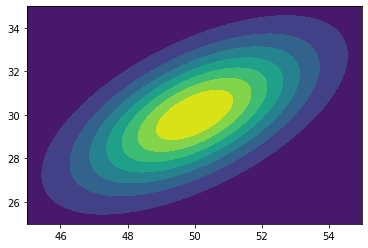

In [4]:
mu = np.array([50., 30.], np.float64)
cov = np.array([[5, 3], [3, 5]], np.float64)
ptial, d_ptial = U(mu, np.linalg.inv(cov)), dU(mu, np.linalg.inv(cov))

X, Y = np.mgrid[45:55:0.078, 25:35:0.078]
pos = np.dstack((X, Y))

gauss = stats.multivariate_normal(mu, cov).pdf(pos)
plt.contourf(X, Y, gauss)
plt.show()

[49.63298997 30.32545761] [5.78919976 5.72631675]
[49.26450725 30.72124897] [3.4114808 3.4932761]
[50.01505209 29.97703563] [4.51650969 4.64078484]
[50.02560152 30.00817244] [5.17723665 5.22004465]
[49.98546429 29.95159611] [4.19582581 4.00583462]
[50.04996725 29.97595062] [5.48281735 5.44648881]
[50.21328643 29.73216539] [5.76934716 5.84508064]
[50.09570719 29.87790595] [5.84640061 5.79462134]
[49.99364081 30.02247492] [5.0605223  4.99521495]
[49.92852145 30.07547896] [4.43945038 4.63906603]
[49.91693199 30.1233635 ] [5.23553247 5.12345348]
[49.91978012 30.06788604] [5.44804619 5.45015645]
[50.12622865 29.90226259] [5.14268526 5.16019666]
[49.98490354 30.00661076] [5.13579111 5.12468716]
[50.00343652 29.99476368] [5.07531639 5.06669847]
[49.95042416 30.04696429] [4.89870174 5.00707675]
[49.93261057 30.07655243] [4.78478953 4.81094114]
[49.88284539 30.10262556] [4.99690554 5.03998992]


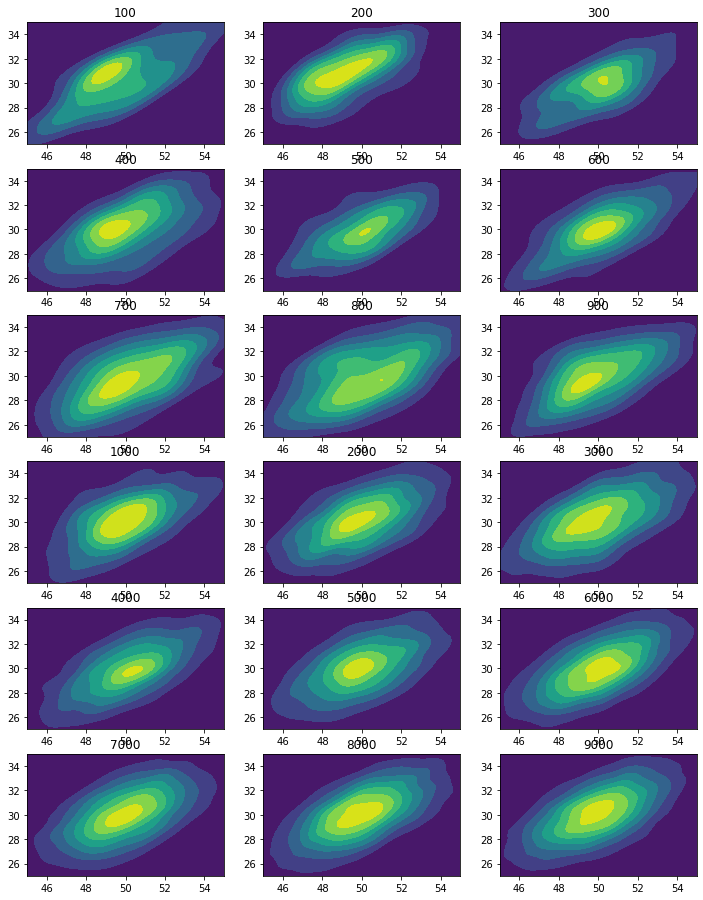

In [5]:
init_func = lambda: mu
tvd = np.array([], np.float64)
plt.figure(figsize=(12,48))
for a, i in enumerate(np.append(np.arange(100, 1000, 100), np.arange(1000, 10000, 1000))):
    samples = hamiltonian_mc(ptial, d_ptial, K, dK, init_func, i)
    print(np.mean(samples, axis=0), np.var(samples, axis=0))
    
    kde = stats.gaussian_kde(samples.T)

    estimate = np.array([kde.evaluate(x) for y in pos for x in y])
    estimate = np.reshape(estimate, (129,129))

    tvd = np.append(tvd, total_variation_distance(estimate, gauss, 0.078))

    plt.subplot(18, 3, a+1)
    plt.title(i)
    plt.contourf(X, Y, estimate)
plt.show()

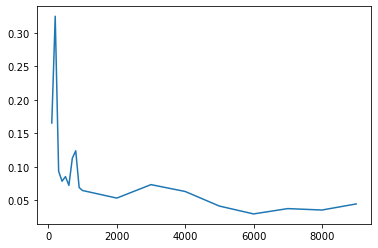

In [6]:
plt.plot(np.append(np.arange(100, 1000, 100), np.arange(1000, 10000, 1000)), tvd)
plt.show()

https://theclevermachine.wordpress.com/2012/11/18/mcmc-hamiltonian-monte-carlo-a-k-a-hybrid-monte-carlo/